<a href="https://colab.research.google.com/github/nellocoder/planets/blob/main/Code_Your_NN_By_Hand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Your Neural Network By Hand!

You will code a little neural network from scratch! Don’t worry, it will be extremely guided. The two most important points being that you learn and you have fun.  

We want our neural network to solve the XOR problem. This is how the data look like:

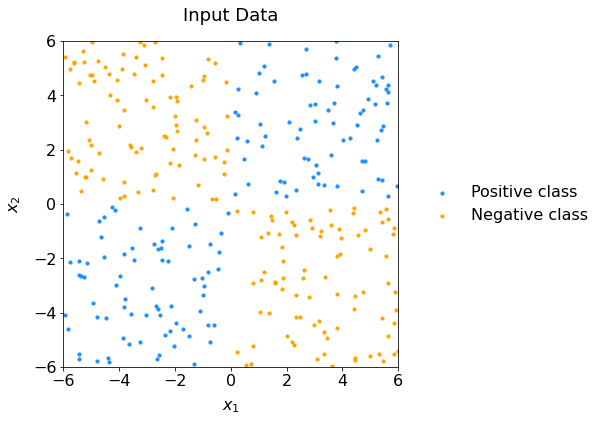

## 0. Setup 
The following is given :-) 

In [ ]:
import numpy as np
import pandas as pd
import random
import math
np.random.seed(42)

import matplotlib.pyplot as plt
FONTSIZE = 16
params = {
         'figure.figsize' : (6,6),
         'axes.labelsize' : FONTSIZE,
         'axes.titlesize' : FONTSIZE+2,
         'legend.fontsize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE,
         'xtick.color'    : 'black',
         'ytick.color'    : 'black',
         'axes.facecolor' : 'white',
         'axes.edgecolor' : 'black',
         'axes.titlepad'  :  20,
         'axes.labelpad'  :  10}
plt.rcParams.update(params)

XNAME = 'x1'; XLABEL = r'$x_1$'
YNAME = 'x2'; YLABEL = r'$x_2$'
RANGE = (-6, 6); STEP = 0.1

def predict(output_node, boundary_value):
  output_node.reshape(-1, 1, 1) # a list (m, 1, 1)
  predictions = np.array(output_node > boundary_value, dtype=int)
  return predictions

def plot_cost_vs_iter(train_costs, test_costs, title="Cost evolution"):

  fig, ax = plt.subplots(figsize=(8, 6))
  iters = np.arange(1,len(train_costs)+1)
  ax.plot(iters, train_costs, color='red', lw=1, label='Training set')
  ax.plot(iters, test_costs, color='blue', lw=1, label='Testing set')
  ax.set_xlabel("Number of iterations"); ax.set_xlim(1, iters[-1])
  ax.set_ylabel("Cost")
  ax.legend(loc="upper right", frameon=False)
  ax.set_title(title)
  plt.show()


def get_decision_surface(weights, biases, boundary=0.5, range=RANGE, step=STEP):

  # Create a grid of points spanning the parameter space:
  x1v, x2v = np.meshgrid(np.arange(range[0], range[1]+step, step),
                         np.arange(range[0], range[1]+step, step))
  
  # Stack it so that it is shaped like X_train: (m,2)
  X_grid = np.c_[x1v.ravel(), x2v.ravel()].reshape(-1,2)

  # Feedforward on all grid points and get binary predictions:
  output = feedforward(X_grid, weights, biases)[-1] # getting only output node
  Ypred_grid = predict(output, boundary)

  return (x1v, x2v, Ypred_grid.reshape(x1v.shape))


def plot_scatter(sig, bkg, ds=None, xname=XNAME, xlabel=XLABEL, yname=YNAME, ylabel=YLABEL, range=RANGE, step=STEP, title="Scatter plot"):

  fig, ax = plt.subplots()

  # Decision surface
  if ds:
    (xx, yy, Z) = ds # unpack contour data
    cs = plt.contourf(xx, yy, Z, levels=[0,0.5,1], colors=['orange','dodgerblue'], alpha=0.3)

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=10, c='dodgerblue', alpha=1, label='Positive class')
  ax.scatter(bkg[xname], bkg[yname], marker='o', s=10, c='orange',     alpha=1, label='Negative class')

  # Axes, legend and plot:
  ax.set_xlim(range); ax.set_xlabel(xlabel)
  ax.set_ylim(range); ax.set_ylabel(ylabel)

  ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False) 
  ax.set_title(title)
  plt.show()

## 1. Get the data


### Mount GDrive
We will retrieve the files of [this folder](https://drive.google.com/drive/folders/1qJaNCiZ6FTOltLuOoMU1sZWmNtgbxlcN?usp=sharing) and read them into panda dataframes `train` and `test`.

First go to the shared folder, right click on the `.csv` file and select “Add shortcut to Drive.”  This will allow you to access the folder from your Gdrive! Then in your Colaboratory tab, write and execute the following lines:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Localizing the file
In Jupyter Notebook, it is possible to write bash commands (the language used in a console, or terminal) by appending a ! at front of a code cell.

The pwd command stands for “print working directory” and will show you were you are currently running your code. 

To list files, use the ls command of ls -l to display more details.


In [ ]:
!ls -l

total 8
drwx------ 6 root root 4096 Mar 27 19:50 gdrive
drwxr-xr-x 1 root root 4096 Mar 24 13:39 sample_data


### Exploring the file
The path below my be different in your Gdrive, so updated it accordingly!

Let's use the following command to display the first 5 rows of the data file:

In [ ]:
!head -n 5 gdrive/MyDrive/ml_a3_data_train.csv

x1,x2,class
-0.136281715144011,3.244889013693518,0
-5.305887881239244,5.6292315616897355,0
-4.147647416709573,-0.22631877774218978,1
-2.1707943210809324,3.9469856898081286,0


To see how many lines your file has, use the “word count” command `wc` with the `-l` option for line:

In [ ]:
! wc -l gdrive/MyDrive/ml_a3_data_train.csv

321 gdrive/MyDrive/ml_a3_data_train.csv


This is useful to know which amount of data we are dealing with.
And we also see the file has a header row. Let’s now load its content in a pythonic way.

### From csv to dataframe
A dataframe is a data structure from the pandas software library designed for tabular data. It can be compared to an array with rows and columns that can be modified in an intuitive way for the programmer. Pandas allows importing data from various file formats. There is a special method for loading the content from a `.csv` file:

In [ ]:
path = "gdrive/MyDrive/"
train = pd.read_csv(path + "ml_a3_data_train.csv")
test  = pd.read_csv(path + "ml_a3_data_test.csv")

## Explore the data

We can show the first rows this way:

In [ ]:
train[:3]

,x1,x2,class
0,-0.136282,3.244889,0
1,-5.305888,5.629232,0
2,-4.147647,-0.226319,1


Nice, isn't it? Then it is possible to do something like this:

In [ ]:
print(f"There are {len(train)} samples in the train set, {len(test)} in the test set.")

There are 320 samples in the train set, 80 in the test set.


## Prepare the data

### Split signal vs background
The class is indicated by the "class" column. By convention we will consider the signal as `class==1` and the background the one for `class==0`. This command will split the train samples into two dataframes: those with targets (real observation) signal and those with targets background:

In [ ]:
sig = train[train['class'] > 0.5]
bkg = train[train['class'] < 0.5]

### From dataframe to NumPy arrays
Let’s now store each column into a python list, as it will be handy for plotting and coding our regressor. Python has lists but we will use a more advanced object from the NumPy library, which is efficiently coded to perform mathematical operations on multi-dimensional arrays and matrices. This will store each column as a `NumPy` array:

In [ ]:
inputs = ['x1', 'x2']
X_train = train[inputs].to_numpy()
y_train = train['class'].to_numpy()

X_test = test[inputs].to_numpy()
y_test = test['class'].to_numpy()

## Plot yourself the data!
Now your turn, call the function `plot_scatter` to plot the data!

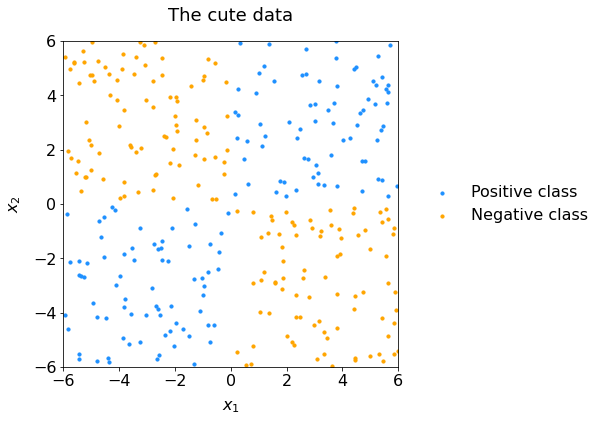

In [ ]:
plot_scatter(sig, bkg, title="The cute data")

## Functions
Let's compute the functions we saw in the lecture. Create a code cell below for each function, copy paste the provided template and fill in the blanks!

__Weighted Sum__  
Write a function `z` that compute the weighted sum of a given activation unit. You do not have to worry about the dimensions of objects here, this will come later. Make sure the names of the arguments are self-explanatory. 

The function will look like:
```python
   def z( ... , ... , ... ):
     # ...
     return #...
```

__Activation Functions and Derivatives__  
 Write the hyperbolic tan and sigmoid activation functions, followed by their derivatives. It will be of the form:

```python
  def tanh(z):
    return #... 

  def sigmoid(z):
    return #... 

  def sigmoid_prime(z):
    return #... 

  def tanh_prime(z):
    return #...
```


In [ ]:
def z( a_Lminus1 , W , b ):
  return a_Lminus1 @ W + b

def sigmoid(z):
  return 1/(1 + np.exp(-z))

def sigmoid_prime(z):
  return sigmoid(z)*(1 - sigmoid(z))

def tanh(z):
  return np.tanh(z)

def tanh_prime(z):
  return 1 - np.tanh(z)**2

__Loss function__  
The loss function for classification is defined as:  

\begin{equation}
L\left( \hat{y}^{(i)}, y^{(i)}\right) = - \left[ \;\; y^{(i)} \log\left( \hat{y}^{(i)} \right) \;\;+\;\; \left(1- y^{(i)}\right) \log\left( 1 - \hat{y}^{(i)} \right) \;\;\right]
\end{equation}

It's derivative is of the form:
\begin{equation}
\frac{\mathrm{d} }{\mathrm{d} \hat{y}^{(i)}} L\left( \hat{y}^{(i)}, y^{(i)}\right) = - \frac{y^{(i)}}{\hat{y}^{(i)}} + \frac{1 - y^{(i)}}{1 - \hat{y}^{(i)}}
\end{equation}

Write it in python:
```python
def L_prime(y_preds, y_obs):
    return #...
```

Note: this function will return a __NumPy array of losses__. 

In [ ]:
def L_prime(y_preds, y_obss):
  epsilon = 1e-9 # to avoid issues with division by zero 
  return -y_obss/(y_preds + epsilon) + (1 - y_obss)/(1 - y_preds + epsilon)


__Cross-entropy cost function__  
Write the cross-entropy cost function: 
\begin{equation}
\text{Cost} = - \frac{1}{m} \sum^m_{i=1} \left[ \;\; y^{(i)} \log( h(x^{(i)} )) \;\;+\;\; (1- y^{(i)}) \log( 1 - h(x^{(i)} )) \;\;\right]
\end{equation}

As I don't know your previous exposure to python, feel free to ask me for help!

```python
def cross_entropy_cost(y_preds, y_vals):
  #...
  return #...
```
Note: this function shall return a scalar (sum over the losses).

In [ ]:
def cross_entropy_cost(y_preds, y_vals):
  m = len(y_vals)
  epsilon = 1e-9 # to avoid issues with log(zero) 
  summand = y_vals*np.log(y_preds + epsilon) + (1-y_vals)*np.log(1 - y_preds + epsilon)
  return -(1/m) * summand.sum()

## Feedforward Propagation

It is time to write the feedforward function! Some information about the network:
* The network has two hidden layers 
* The nodes of the hidden layers use the hyperbolic tangent as activation function
* The output layer uses the sigmoid function 

 
We do not have to know the number of activation units in each layer as the code here is made to be general. The weights and biases are given as input, stored in lists. Again, you do not have to worry about the indices yet (and I have simplified it by reshaping the input data for you). 

Complete the function below that does the feedforward propagation of the network, using the equations shown in class. Look at the output to see how to name your variables!

In [ ]:
def feedforward(input_X, weights, biases):

  W1, W2, W3 = weights ; b1, b2, b3 = biases

  m  = len(input_X) 
  a0 = input_X.reshape((m, 1, -1))

  # First layer
  z1 = z(a0, W1, b1)
  a1 = tanh(z1)

  # Second layer
  z2 = z(a1, W2, b2)
  a2 = tanh(z2)

  # Third layer
  z3 = z(a2, W3, b3)
  a3 = sigmoid(z3)
  
  nodes = [a0, z1, a1, z2, a2, z3, a3]

  return nodes


## Predict function
It will be handy to have a function making predictions. It is part of the setup. Have a look and try to understand how it works. 

* What type of values does the function `predict` return? 
* What is the `output_node` in the context of our 2-hidden-layered neural network? 
* After successfully executing the `feedforward` function, how would you call the function `predict`?


## Neural Network Training
The core of the artificial brain! The code below is a skeleton. You will have to complete it. To help you further, hyperparameters are given. You should replace the `#...` with your own code.

In [ ]:
# Hyperparameters
alpha = 0.03
N = 300 # epochs

# Initialization 
m = len(X_train)     # number of data samples
n = X_train.shape[1] # number of input features
q = 3 # number of nodes in first hidden layer
r = 2 # number of nodes in second hidden layer

# WEIGHT MATRICES + BIASES
W1 = np.random.random(( n, q ))
W2 = np.random.random(( q, r ))
W3 = np.random.random(( r, 1 ))
b1 = np.random.random(( 1, q ))
b2 = np.random.random(( 1, r ))
b3 = np.random.random(( 1, 1 ))

# OUTPUT LAYER
y_train = np.reshape(y_train, (-1, 1, 1))
y_test  = np.reshape(y_test , (-1, 1, 1))

# Storing cost values for train and test datasets
costs_train = []
costs_test  = []
debug = False

print("Starting the training\n")

# -------------------
#   Start iterations
# -------------------
for t in range(1, N+1):

  # FORWARD PROPAGATION
  # Feedforward on test data:
  nodes_test =  feedforward(X_test, [W1, W2, W3], [b1, b2, b3])
  ypreds_test =  nodes_test[-1] # returns a3

  # Feedforward on train data:
  a0, z1, a1, z2, a2, z3, a3 = feedforward(X_train, [W1, W2, W3], [b1, b2, b3])
  ypreds_train = a3

  # Cost computation and storage
  J_train = cross_entropy_cost(ypreds_train, y_train)
  J_test  = cross_entropy_cost(ypreds_test,  y_test )
  costs_train.append(J_train)
  costs_test.append(J_test)

  if (t<=100 and t % 10 == 0) or (t>100 and t % 100 == 0):
      print(f"Iteration {t}\t Train cost = {J_train:.4f}  Test cost = {J_test:.4f}   Diff = {J_test-J_train:.5f}")

  # BACKWARD PROPAGATION
  # Errors delta:
  delta_3 = L_prime(a3, y_train)*sigmoid_prime(z3)
  delta_2 = (delta_3@(W3.T))*tanh_prime(z2)
  delta_1 = (delta_2@(W2.T))*tanh_prime(z1)
  
  # Partial derivatives:
  dCostdW3 = np.sum( np.transpose(a2, (0, 2, 1))@delta_3, axis=0 )
  dCostdW2 = np.sum( np.transpose(a1, (0, 2, 1))@delta_2, axis=0 )
  dCostdW1 = np.sum( np.transpose(a0, (0, 2, 1))@delta_1, axis=0 )
  dCostdb3 = np.sum(delta_3, axis=0)
  dCostdb2 = np.sum(delta_2, axis=0)
  dCostdb1 = np.sum(delta_1, axis=0)

  if debug and t<3:
    print(f"a0: {a0.shape} a1: {a1.shape} a2: {a2.shape} a3: {a3.shape} ")
    print(f"W3: {W3.shape} z1: {z1.shape} z2: {z2.shape} z3: {z3.shape} ")
    print(f"dCostdW3: {dCostdW3.shape} dCostdW2: {dCostdW2.shape} dCostdW1: {dCostdW1.shape}") 

  # Update of weights and biases
  W3 = W3 - alpha * dCostdW3
  W2 = W2 - alpha * dCostdW2
  W1 = W1 - alpha * dCostdW1
  b3 = b3 - alpha * dCostdb3 
  b2 = b2 - alpha * dCostdb2
  b1 = b1 - alpha * dCostdb1

print(f'\nEnd of gradient descent after {t} iterations')

Starting the training

Iteration 10	 Train cost = 1.3041  Test cost = 1.0210   Diff = -0.28316
Iteration 20	 Train cost = 0.1217  Test cost = 0.0695   Diff = -0.05221
Iteration 30	 Train cost = 0.0288  Test cost = 0.0270   Diff = -0.00182
Iteration 40	 Train cost = 0.0139  Test cost = 0.0146   Diff = 0.00072
Iteration 50	 Train cost = 0.0096  Test cost = 0.0101   Diff = 0.00051
Iteration 60	 Train cost = 0.0073  Test cost = 0.0077   Diff = 0.00039
Iteration 70	 Train cost = 0.0059  Test cost = 0.0063   Diff = 0.00032
Iteration 80	 Train cost = 0.0050  Test cost = 0.0053   Diff = 0.00026
Iteration 90	 Train cost = 0.0043  Test cost = 0.0045   Diff = 0.00023
Iteration 100	 Train cost = 0.0038  Test cost = 0.0040   Diff = 0.00020
Iteration 200	 Train cost = 0.0017  Test cost = 0.0018   Diff = 0.00009
Iteration 300	 Train cost = 0.0011  Test cost = 0.0012   Diff = 0.00006

End of gradient descent after 300 iterations


### Some Helpers

__Hints on weight initialization__  

The weight matrices and bias vectors can be simply initialized with a random number between 0 and 1. Use:
```python
an_i_by_j_matrix = np.random.random(( i , j ))
```
The double parenthesis is important to get the correct shape. To make your code modular, use the variables encoding the number of activation nodes on the first and second hidden layers (it's in the provided skeleton-code!).

__Feedforward and predict__  
* To return the last element of a list: `my_list[-1]`

__Dimension of Nodes__  
At the end of the lecture, we had equations written with indices. In python, we will use 3D NumPy arrays of shape ($i$, $j$, $k$), with 
* $i$ the sample index
* $j$ the number of rows of the node vector
* $k$ the number of columns

__Matrix/Vector Operations__  
* In python the matrix multiplication is done using `@`
* The element-wise multiplication is done using `*`

__Transpose__  
* To transpose a matrix M: `M.T` 
* To transpose 3D arrays, the indices to reorder are indicated as argument: `np.transpose(my3Darray, (0, 2, 1))` will transpose the two last dimensions.

__Summing__  
* To sum a 3D array on the first index: `np.sum(my3Darray, axis=0)`

## Plots

### Cost evolution
 Call the provided function to plot the cost evolution of both the training and testing sets.

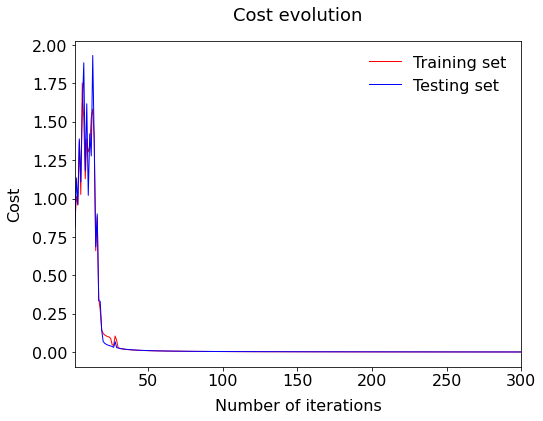

In [ ]:
plot_cost_vs_iter(costs_train, costs_test)

### Scatter Plot
Use the get_decision_surface and plot_scatter functions to visualize the decision boundaries of your trained neural network. Did your neural network successfully learn the XOR function?

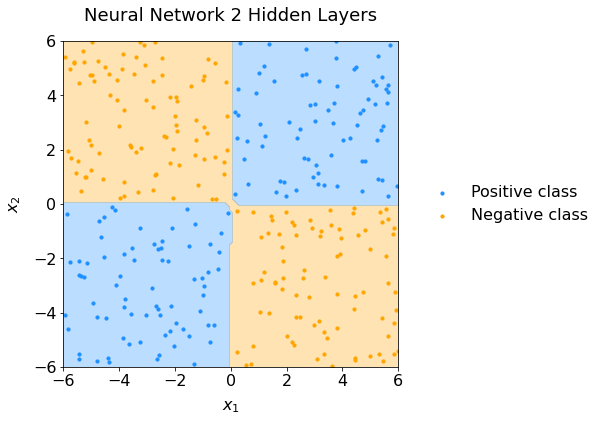

In [ ]:
plot_scatter(sig, bkg, 
             ds=get_decision_surface([W1, W2, W3],[b1, b2, b3]), 
             title="Neural Network 2 Hidden Layers")

The neural network has learned the XOR pattern!

This conclude this first endeavour for today, but I hope it will be the start of a long journey of exploration for you! Machine Learning is fascinating and incredibly vast, not to mention the recent boom in the past decade.

I wish you a lot of joy while discovering more advanced algorithms.

Happy to stay in touch, provide resources and hear from your future activities using Artificial Intelligence!